I only use the landmark_id from 0 to 499. The data size is about 30000.Because the original data size is about 1,200,000, you need much time to download these images. Some images have a problem(404 not found).We need to remove the image from the data. "new_train_id0_499.csv" is the data which has been processed the 404 problem.

If you like my analysis, following my Github:https://github.com/SonyFriend/GoogleLandmark 

After you have download these images,you can  go to the website:https://bulkresizephotos.com/zh-tw  to change these images to 32*32 pixels.

In [1]:
import requests
from bs4 import BeautifulSoup
import lxml
import os
import urllib
import sys
import pandas as pd
import numpy as np
from PIL import Image
import cv2
import csv
import multiprocessing
import matplotlib.pyplot as plt
import seaborn as sns

##https://bulkresizephotos.com/zh-tw <- This website can change your image to 32*32 pixels
new_train=pd.read_csv('../input/landmark-id-from-0-to-499/new_train_id0_499.csv')
filename=os.listdir("../input/graph-id0-499/landgraphnew_0_499")
filename.sort(key=lambda x:int(x[:-4]))
img=[]
for file in filename:
	img.append(np.array(Image.open("../input/graph-id0-499/landgraphnew_0_499/"+file)))
img=np.array(img)

In [2]:
new_train.groupby(['landmark_id']).agg('count').sort_values(by='id',ascending=False).style.background_gradient(cmap='Blues')


,id,url
landmark_id,,
428.0,2557,2557
233.0,1285,1285
165.0,1275,1275
152.0,942,942
253.0,806,806
384.0,661,661
355.0,568,568
362.0,539,539
193.0,480,480


In [3]:
np.random.seed(1337)
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Convolution2D,Dense,MaxPool2D,Activation,Dropout,Flatten
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.layers.normalization import BatchNormalization
X_train,X_test,y_train,y_test=train_test_split(img,new_train['landmark_id'],test_size=0.2)
y_train=y_train.astype(int)
y_test=y_test.astype(int)
y_train=np.array(y_train).reshape(-1,1)
y_test=np.array(y_test).reshape(-1,1)
X_train=X_train.reshape(-1,32,32,3)/255 #Normalize
X_test=X_test.reshape(-1,32,32,3)/255
y_train=np_utils.to_categorical(y_train,num_classes=500)
y_test=np_utils.to_categorical(y_test,num_classes=500)#landmark_id is from 0 to 499

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

Train on 17776 samples, validate on 4445 samples
Epoch 1/100
17776/17776 [==============================] - 7s 383us/step - loss: 4.7795 - acc: 0.1568 - val_loss: 5.6479 - val_acc: 0.1600
Epoch 2/100
17776/17776 [==============================] - 2s 120us/step - loss: 3.6491 - acc: 0.2749 - val_loss: 5.8720 - val_acc: 0.1309
Epoch 3/100
17776/17776 [==============================] - 2s 115us/step - loss: 3.1769 - acc: 0.3430 - val_loss: 5.5575 - val_acc: 0.2355
Epoch 4/100
17776/17776 [==============================] - 2s 106us/step - loss: 2.8511 - acc: 0.3917 - val_loss: 5.3303 - val_acc: 0.2225
Epoch 5/100
17776/17776 [==============================] - 2s 107us/step - loss: 2.6350 - acc: 0.4258 - val_loss: 4.8608 - val_acc: 0.3246
Epoch 6/100
17776/17776 [==============================] - 2s 106us/step - loss: 2.4441 - acc: 0.4543 - val_loss: 4.8122 - val_acc: 0.3332
Epoch 7/100
17776/17776 [==============================] - 2s 106us/step - loss: 2.3253 - acc: 0.4762 - val_loss: 4.6

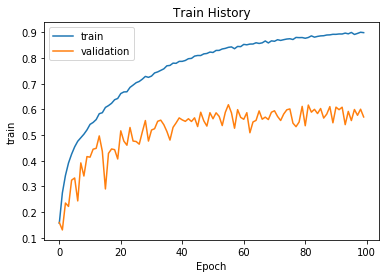

In [4]:
model=Sequential()
model.add(Convolution2D(filters=32,kernel_size=(3,3),input_shape=(32,32,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(rate=0.35))

model.add(MaxPool2D(pool_size=(2,2),padding='same'))

model.add(Convolution2D(filters=64,kernel_size=(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(rate=0.45))

model.add(MaxPool2D(pool_size=(2,2),padding='same'))

model.add(Flatten())

model.add(Dense(1024,activation='relu'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(rate=0.75))

model.add(Dense(500,activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

train_history=model.fit(X_train,y_train,validation_split=0.2,epochs=100,batch_size=128,verbose=1)
accuracy=model.evaluate(X_test,y_test,verbose=1)
print("test accuracy:",accuracy[1])#accuracy for test set



def show_train_history(train_history,train,validation):
	plt.plot(train_history.history[train])
	plt.plot(train_history.history[validation])
	plt.title('Train History')
	plt.ylabel('train')
	plt.xlabel('Epoch')
	plt.legend(['train','validation'],loc='upper left')
	plt.show()

show_train_history(train_history,'acc','val_acc') #acc:accuracy for training set. val_acc:accuracy for validation.